In [1]:
using FFTW 
using Plots
using LaTeXStrings
using Distributions
using Statistics
using Interact

WebIO._IJuliaInit()

In [2]:
#using DynamicalSystems
#using WebIO
#using Conda

NLSE:

$$i\frac{\partial u}{\partial \xi}+\beta\frac{\partial^2 u}{\partial \tau^2}+\lambda|u|^2u=0$$

SE:

$$i\hbar\frac{\partial \Psi}{\partial t}=-\frac{\hbar^2}{2m}\frac{\partial^2\Psi}{\partial x^2}+V(x)\Psi$$
$$i\frac{\partial \Psi}{\partial t}=-\frac{\hbar}{2m}\frac{\partial^2\Psi}{\partial x^2}+\frac{1}{\hbar}V(x)\Psi$$

$$\beta=\frac{\hbar}{2m}$$
$$\lambda=\frac{1}{\hbar}$$
$$i\frac{\partial \Psi}{\partial t}=-\beta\frac{\partial^2\Psi}{\partial x^2}+\lambda V(x)\Psi$$


$$\hat{L}\equiv\beta\frac{\partial^2 }{\partial x^2}; \hat{N}\equiv-\lambda V(x)$$
Reescribiendo en terminos de $L$ y $N$
$$\frac{\partial \Psi}{\partial t}=(i\hat{L}+i\hat{N})\Psi$$

$$\Psi(x,t)=e^{it(\hat{L}+\hat{N})}\Psi(x,0)$$

$$\Psi(x,t+dt)=e^{idt(\hat{L}+\hat{N})}\Psi(x,t)$$
$$\Psi(x,t+dt)=e^{idt\hat{L}}e^{i dt\hat{N}}\Psi(x,t)$$

APLICANDO TRANSOFRAMA DE DOURIER A LA parte lineal

$$\mathcal{F}\{\frac{\partial^n u}{\partial t^n}\}=(\omega i)^n \hat{u} \therefore$$

$$\mathcal{F}\{\hat{L}\Psi\}=\beta\frac{\partial^2 \hat{\Psi}}{\partial t^2}=\beta(\omega i)^2 \hat{\Psi}$$

Sustituyenbdo:

$$\hat{\Psi(x,t+dt)}=e^{idt(\beta(\omega i)^2)}\mathcal{F}\{e^{idt\hat{N}}\Psi(x,t)\}$$
$$\Psi(x,t+dt)=\mathcal{F}^{-1}\{e^{idt(\beta(\omega i)^2)}\mathcal{F}\{e^{idt\hat{N}}\Psi(x,t)\}\}$$



Condicion inicial
$$\Psi(x,0)=\sqrt{\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}}e^{i k_0 x}$$

In [3]:
function V(t, a, V0)
    Vi = zeros(length(t))
        Vi[end-2:end] = 10000*ones(3)
    Vi[1:3] = 10000*ones(3)
    Vi[(t .> -a) .& (t .< a)] .= V0
    return Vi
end


V (generic function with 1 method)

In [4]:
function NL(u, lam, ts, a, V0)
    return -lam .* V(ts, a, V0)
end


NL (generic function with 1 method)

In [5]:
function LL(n, N, L)
    dw = 2π / L
    ws = range(-N/2, stop=(N/2 - 1), step=1) * dw
    wss = fftshift(ws)
    return (1im * wss).^n
end

LL (generic function with 1 method)

In [6]:
function tss(tf, xf, N)
    dt = tf / N
    dx = (dt^2) / 4
    xs = 0:dx:xf
    Nx = length(xs)
    ts=range(0,tf,length=N)
    if N % 2 == 0
        ts =( (-N / 2):(N / 2 - 1)).* dt
    end
    #T=repeat(ts',Nx)
    #X=repeat(xs',N)
    
    return ts, xs
end



tss (generic function with 1 method)

In [7]:
function step(aa, N, lam, Beta, xs, ts, u0,V0)
    a = aa / 2
    Nx = length(xs)
    dt = diff(ts)[1]
    dx = diff(xs)[1]
    tf = ts[end]
    xf = xs[end]

    us = ones(Nx, N)*0im
    us[1, :] .= u0
    us[:, 1] .= 0
    us[:, end] .= 0
    LL1=LL(2, N, tf)
    for i in 1:Nx-1
        NL_result = NL(us[i, :], lam, ts, a,V0)
        us[i+1, :] .= ifft((exp.(1im * dx * LL1 * Beta) .* fft(exp.(1im * dx * NL_result) .* us[i, :])))
        #us[i+1, :] .= ifft(fft(exp(1im * dx * LL(2, N, tf) * Beta) .* fft(exp(1im * dx * NL(us[i, :], lam, ts, a)) .* us[i, :])))
    end
    ll = Nx
    NNN=400
    if ll > NNN
        step = div(ll, NNN)  # Calculate the step size to get around 1000 elements
        lll = 1:step:ll
        lll = collect(lll)  # Convert the range to a vector if needed
    else
        lll = 1:ll  # Keep the original indices if ll is 1000 or fewer
    end
    
    kk = N
    if kk > NNN
        stepk = div(kk, NNN)  # Calculate the step size to get around 1000 elements
        kkk = 1:stepk:kk
        kkk = collect(kkk)  # Convert the range to a vector if needed
    else
        kkk = 1:kk  # Keep the original indices if ll is 1000 or fewer
    end
    return us[lll,kkk],length(lll),xs[lll],ts[kkk]
end


step (generic function with 1 method)

In [8]:
function df(y, dt)
    yp = copy(y)
    n = length(y)
    
    for i in 2:n-1
        yp[i] = (y[i+1] + y[i-1]) / (2 * dt)
    end
    
    yp[1] = yp[2]
    yp[end] = yp[end-1]
    
    return yp
end


df (generic function with 1 method)

In [9]:
function p(u, ts)
    return trapz(ts, abs2.(u))
end


p (generic function with 1 method)

# Solucion Ecuacionde Shrodinger

In [66]:
ħ=1/(2*π)#
m=1
λ=1/ħ
β=ħ/(2*m)
k=1
ω=sqrt(k/m)
#####
L=2*130 ###distancia de x
N=2000 ###Numero de putnos en t
z=150#Limite de tiempo a simular

ts1,xs1=tss(L,z,N);
μ=-90
σ=5
k0=4;##########Momento inicial

#### condicion Inicial
Condicion inicial
$$\Psi(x,0)=\sqrt{\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}}e^{i k_0 x}$$
de tal manera que $\int_\infty^\infty|\Psi|^2=1$

In [67]:
u0=sqrt.(1/(σ*sqrt(2*π))*exp.(-(1/2)*((ts1.-μ)./σ).^2)).*exp.(1im*k0*ts1);
sum(abs2.(u0)*diff(ts1)[1])########Comprobacion de la integral

0.9999999999999646

In [68]:
V0=0.3### Haltura del potencial
G=100 ###Grosor de la pared
us,Nx,xs,ts=step(G,N,λ,β,xs1,ts1,u0,V0);

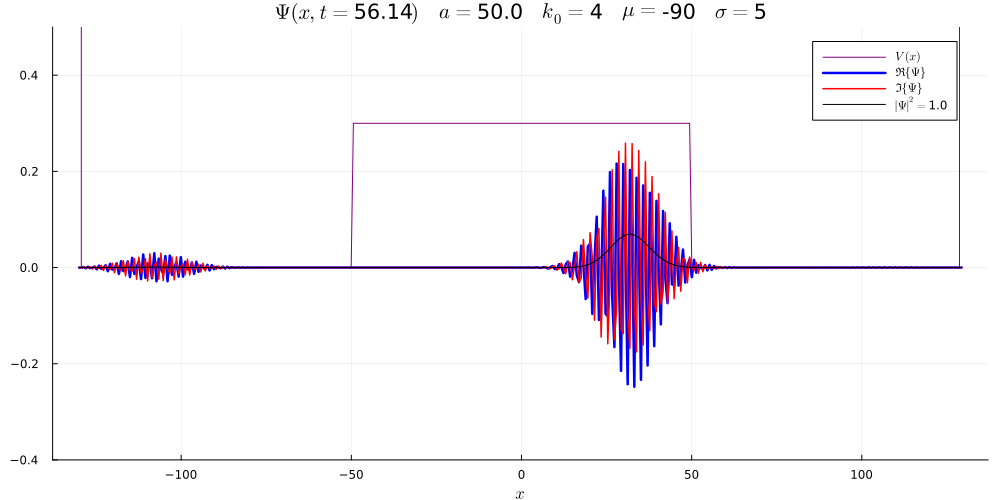

In [69]:
ii=Int(Nx/2-50)
plot(ts,V(ts,G/2,V0),label=L"V(x)",color="Purple",size=(1000,500),xlabel=L"x",title=L"\Psi(x,t="*string(round(xs[ii],digits=2))*L")"*"   "*L"a="*string(G/2)*"   "*L"k_0="*string(k0)*"   "*L"\mu="*string(μ)*"   "*L"\sigma="*string(σ))
    plot!(ts,real.(us[ii,:]),label=L"\Re \{\Psi \}",lw=2.5,color="blue",ylim=[-0.4,0.5])
    plot!(ts,imag.(us[ii,:]),label=L"\Im \{\Psi \}",lw=1.5,color="red")
    plot!(ts,abs2.(us[ii,:]),label=L" |\Psi|^2="*string(round(sum(abs2.(us[ii,:])*diff(ts)[1]),digits=2)),color="black")
#plot!(ts,real.(us1[ii,:]),label=L"\Re \{\Psi \}",lw=2.5,color="blue",ylim=[-0.4,0.5])

[ Info: Saved animation to C:\Users\Arif\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\Quantum Mechs\Reto\Fase3\Shrod.gif


Plots.AnimatedGif("C:\\Users\\Arif\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\Quantum Mechs\\Reto\\Fase3\\Shrod.gif")
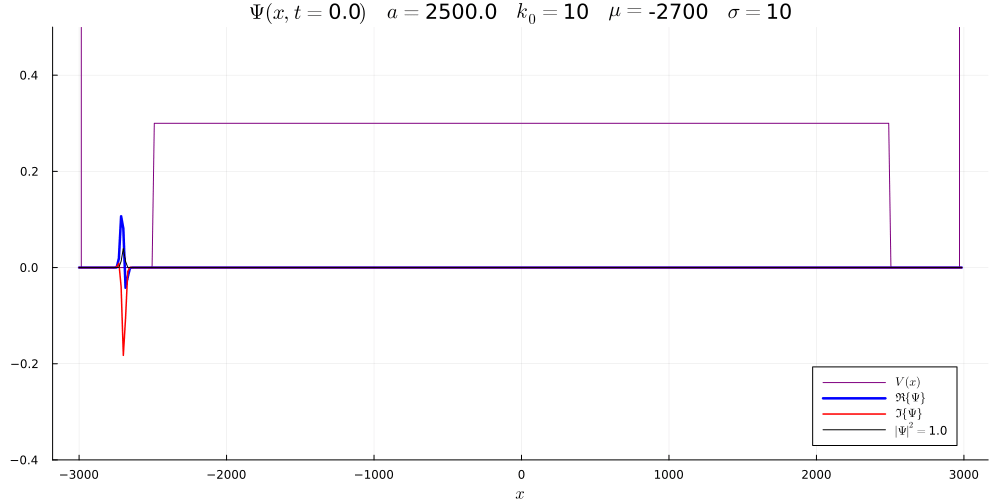

In [47]:
animac(ts,us,us*0,xs,"Shrod",Nx)

# Analizando el efecto hartman

In [12]:
ħ=1/(2*π)#
m=1
λ=1/ħ
β=ħ/(2*m)
k=1
ω=sqrt(k/m)
#####
L=2*3000 ###distancia de x#############################################################################A modificar
N=1000 ###Numero de putnos en x
z=200#Limite de tiempo a simular

ts1,xs1=tss(L,z,N);
μ=-2700
σ=30
k0=10;
###CI
u0=sqrt.(1/(σ*sqrt(2*π))*exp.(-(1/2)*((ts1.-μ)./σ).^2)).*exp.(1im*k0*ts1);
sum(abs2.(u0)*diff(ts1)[1])

1.0

In [13]:
V0=0.1### Haltura del potencial
G=5000 ###Grosor de la pared
us,Nx,xs,ts=step(G,N,λ,β,xs1,ts1,u0,V0);

## Paquete Sin Potencial

In [15]:
V01=0### Haltura del potencial
G1=1 ###Grosor de la pared
us1,Nx,xs,ts=step(G1,N,λ,β,xs1,ts1,u0,V01);

In [ ]:
@manipulate for ii in 1:5:Nx
    plot(ts,V(ts,G/2,V0),label=L"V(x)",color="Purple",size=(1000,500),xlabel=L"x",title=L"\Psi(x,t="*string(round(xs[ii],digits=2))*L")"*"   "*L"a="*string(G/2)*"   "*L"k_0="*string(k0)*"   "*L"\mu="*string(μ)*"   "*L"\sigma="*string(σ),ylim=[-0.4,0.5])
    #plot!(ts,real.(us[ii,:]),label=L"\Re \{\Psi \}",lw=2.5,color="blue")
    #plot!(ts,imag.(us[ii,:]),label=L"\Im \{\Psi \}",lw=1.5,color="red")
    plot!(ts,abs2.(us1[ii,:]),label=L"|\Psi_2|^2"*"  "*L"V_0=0",lw=1.6,color="orange")
    plot!(ts,abs2.(us[ii,:]),label=L" |\Psi|^2="*string(round(sum(abs2.(us[ii,:])*diff(ts)[1]),digits=2)),color="black")
end

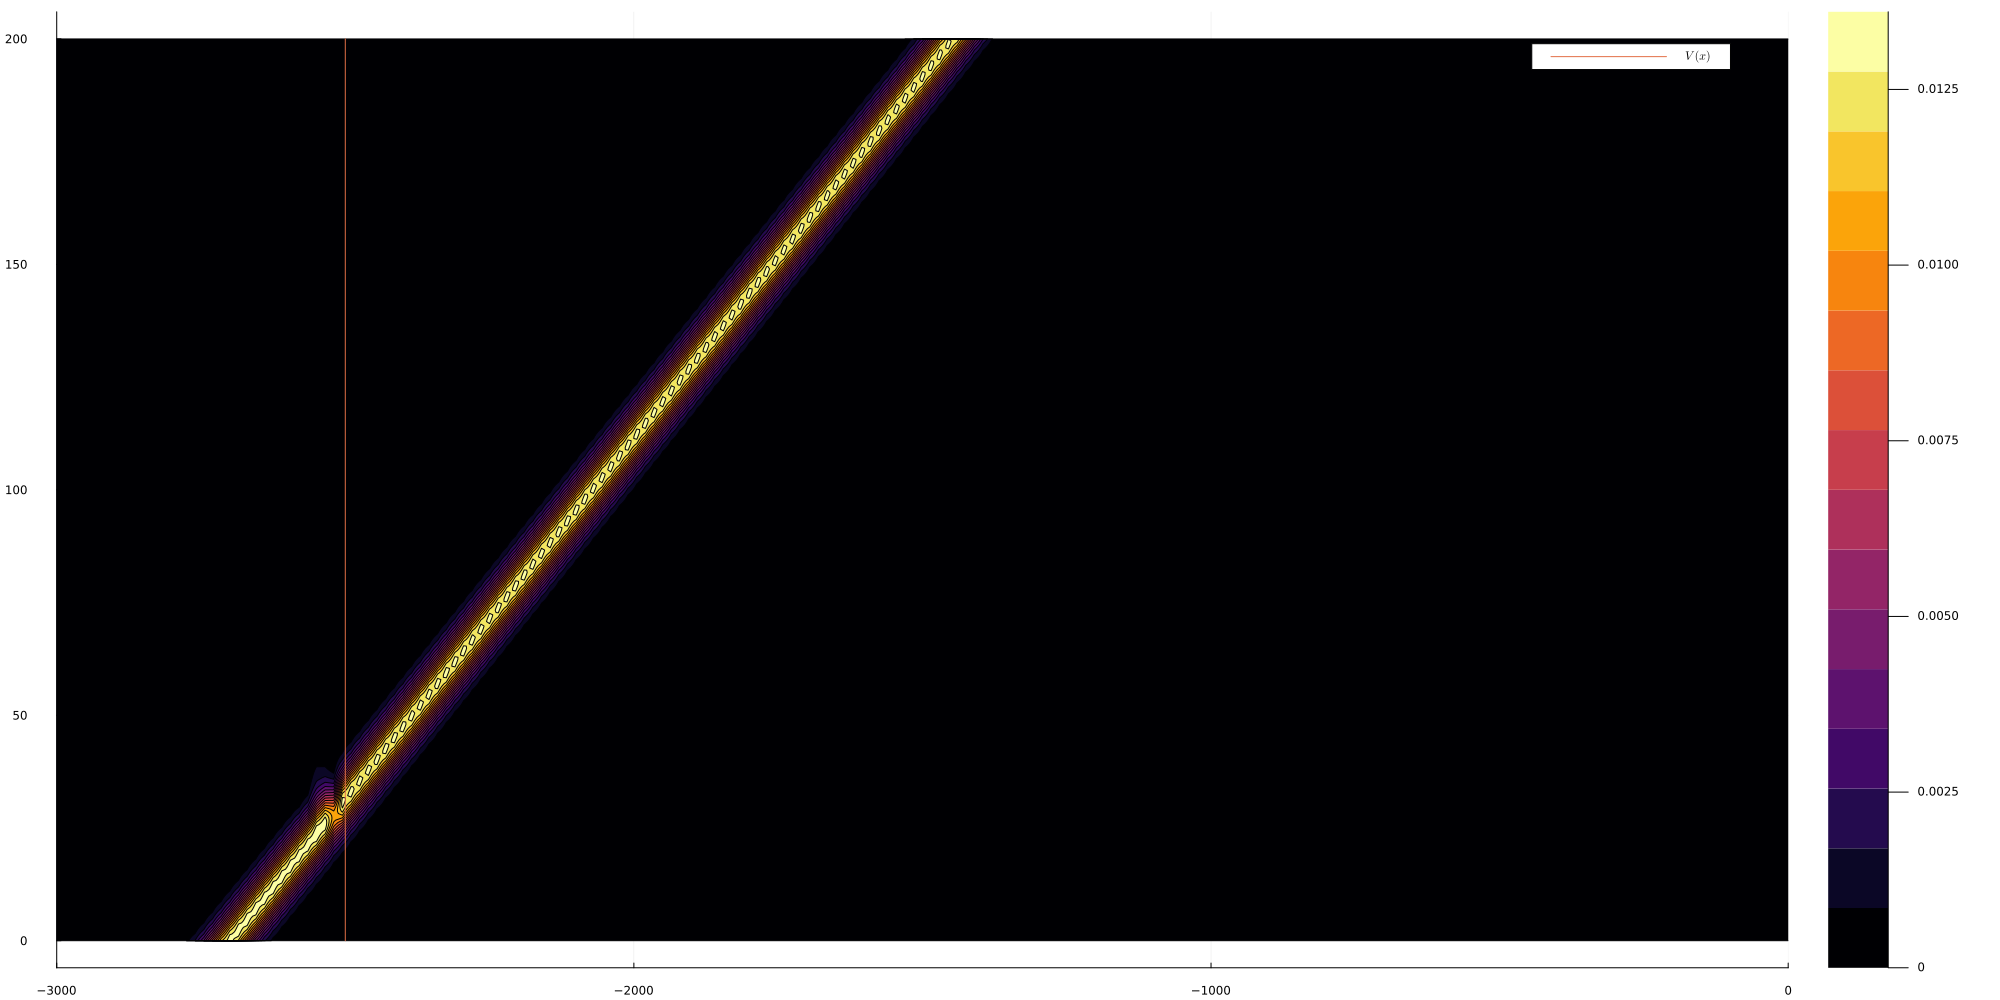

In [144]:
contourf(ts,xs,abs2.(us),xlim=[-3000,0])
#contourf!(ts,xs,abs2.(us1),xlim=[-3000,0])
plot!(-G/2*ones(2),[0;z],label=L"V(x)")

[ Info: Saved animation to C:\Users\Arif\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\Quantum Mechs\Reto\Fase3\Efecto_Hartman.gif


Plots.AnimatedGif("C:\\Users\\Arif\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\Quantum Mechs\\Reto\\Fase3\\Efecto_Hartman.gif")
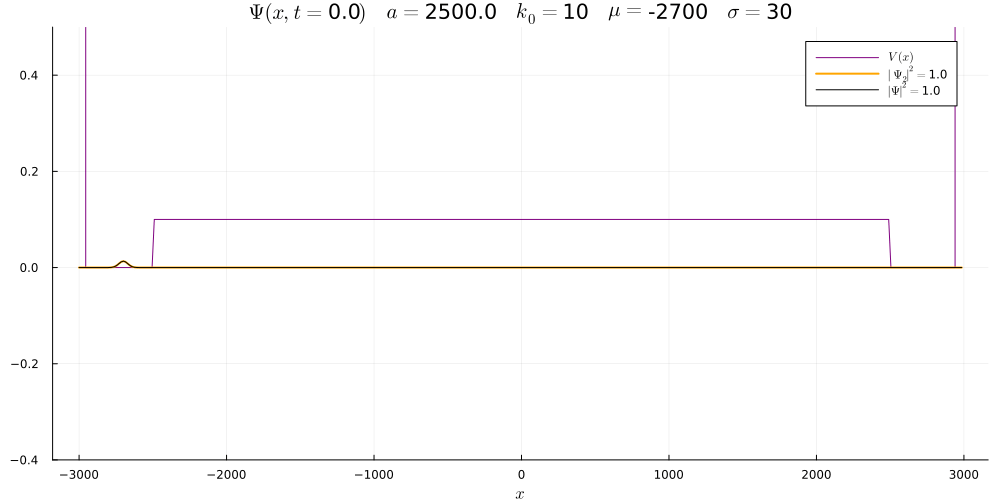

In [24]:
animac(ts,us,us1,xs,"Efecto_Hartman",Nx)

In [23]:
function animac(xs,ys,ys1,ts,tit,n)
    anim2d=@animate for i in 1:1:n;
        gr(size=(2000,1000))
        plot(xs,V(xs,G/2,V0),label=L"V(x)",color="Purple",size=(1000,500),xlabel=L"x",title=L"\Psi(x,t="*string(round(ts[i],digits=2))*L")"*"   "*L"a="*string(G/2)*"   "*L"k_0="*string(k0)*"   "*L"\mu="*string(μ)*"   "*L"\sigma="*string(σ),ylim=[-0.4,0.5])
        #plot!(xs,real.(ys[i,:]),label=L"\Re \{\Psi \}",lw=2.5,color="blue")
        #plot!(xs,imag.(ys[i,:]),label=L"\Im \{\Psi \}",lw=1.5,color="red")
        plot!(xs,abs2.(ys1[i,:]),label=L" |\Psi_2|^2="*string(round(sum(abs2.(ys1[i,:])*diff(xs)[1]),digits=2)),color="orange",lw=2)
        plot!(xs,abs2.(ys[i,:]),label=L" |\Psi|^2="*string(round(sum(abs2.(ys[i,:])*diff(xs)[1]),digits=2)),color="black")
        #plot!(xs,abs2.(us1[ii,:]),label=L"|\Psi_2|^2"*"  "*L"V_0=0",lw=1.6,color="orange")
    end;
    gif(anim2d,tit*".gif",fps=24)
end

animac (generic function with 1 method)